In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
# del os.environ['MKL_NUM_THREADS']
# del os.environ['OMP_NUM_THREADS']
# del os.environ['OPENBLAS_NUM_THREADS']

In [4]:
import sys
sys.path.append('..')
from pysb.simulator import ScipyOdeSimulator, SimulationResult
from pydyno.visualize_simulations import VisualizeSimulations
# from pydyno.tools.miscellaneous_analysis import simulate_changing_parameter_in_time
from pydyno.visualize_discretization import visualization_path
from pydyno.seqanalysis import SeqAnalysis
# from pydream.convergence import Gelman_Rubin
from full_earm_2m_calibration.earm2_flat import model
from pydyno.discretization import PysbDomPath
import numpy as np
from time import time
import pandas as pd
from pysb.pattern import SpeciesPatternMatcher, ReactionPatternMatcher
import matplotlib.pyplot as plt
import seaborn as sns
from pydyno.util import sig_apop, curve_fit_ftn
import scipy.interpolate
import copy
from textwrap import wrap

%matplotlib inline

# Load sampled parameter vectors from PyDREAM

In [6]:
chain0 = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_sampled_params_chain_0_2000000.npy')
chain1 = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_sampled_params_chain_1_2000000.npy')
chain2 = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_sampled_params_chain_2_2000000.npy')
chain3 = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_sampled_params_chain_3_2000000.npy')
chain4 = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_sampled_params_chain_4_2000000.npy')

chain0_logp = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_logps_chain_0_2000000.npy')
chain1_logp = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_logps_chain_1_2000000.npy')
chain2_logp = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_logps_chain_2_2000000.npy')
chain3_logp = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_logps_chain_3_2000000.npy')
chain4_logp = np.load('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_logps_chain_4_2000000.npy')

# Supplementary Figure 5: PyDREAM chains' logp values

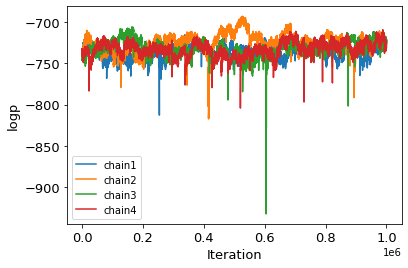

In [7]:
fig_lopg, ax_logp = plt.subplots()
# ax_logp.plot(chain0_logp[1000000:], label='chain0')
ax_logp.plot(chain1_logp[1000000:], label='chain1')
ax_logp.plot(chain2_logp[1000000:], label='chain2')
ax_logp.plot(chain3_logp[1000000:], label='chain3')
ax_logp.plot(chain4_logp[1000000:], label='chain4')
# plt.ylim(0, 0.5)
ax_logp.legend()

ax_logp.set_xlabel('Iteration')
ax_logp.set_ylabel('logp')
ax_logp.tick_params(axis='both', labelsize=13)
ax_logp.xaxis.label.set_size(13)
ax_logp.yaxis.label.set_size(13)
# ax_logp.ticklabel_format(style='sci',scilimits=(-3,4),axis='x')

fig_lopg.savefig('logp_traces.png', dpi=150, bbox_inches='tight')

# Obtain the 54953 most likely parameters

In [9]:
# Function taken from https://jtemporal.com/kmeans-and-elbow-method/
def optimal_number_of_param_sets(counts, min_idx, max_idx):
    x1, y1 = min_idx, counts[0]
    x2, y2 = max_idx, counts[len(counts)-1]

    distances = []
    for i in range(len(counts)):
        x0 = i+2
        y0 = counts[i]
        numerator = np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [10]:
# Number of unique parameters: 719209
# Number of parameter vectors using the elbow score: 54953

total_iterations = chain0.shape[0]
iterations_range = range(total_iterations)

burnin = int(total_iterations / 2)

sampled_log_pars = np.concatenate((chain1[burnin:, :], chain2[burnin:, :],
                                   chain3[burnin:, :], chain4[burnin:, :]))
# get unique parameters
u, indices, counts = np.unique(sampled_log_pars, return_index=True, 
                               return_counts=True, axis=0)

# sort unique parameter counts from highest to lowest count
sorted_counts = np.argsort(counts)[::-1]

In [11]:
# use the elbow method to obtain optimal number of parameters to simulate
n_likely_pars = optimal_number_of_param_sets(counts[sorted_counts], 0, len(u))

most_likely_pars = u[sorted_counts[:n_likely_pars]]
unlog_pars = 10**most_likely_pars

In [12]:
rate_params = model.parameters_rules()[:]
param_values = np.array([p.value for p in model.parameters])
rate_mask = np.array([p in rate_params for p in model.parameters])

all_pars = np.tile(param_values, (n_likely_pars, 1))

In [13]:
# get indices of parameters in the model to assign the parameter values
kpar_idxs = []
ic_par_idxs = []
initials_values = []
for i, j in enumerate(model.parameters):
    if j in model.parameters_initial_conditions():
        ic_par_idxs.append(i)
        initials_values.append(j.value)
    else:
        kpar_idxs.append(i)

initials_values = np.array(initials_values)

initials_to_add = np.tile(initials_values, (n_likely_pars, 1))

In [14]:
all_pars[:, rate_mask] = unlog_pars
all_pars[:, ic_par_idxs] = initials_to_add

In [ ]:
# all_pars = np.load('most_likely_54953_parameters.npy')

# Probabilities of parameter sets

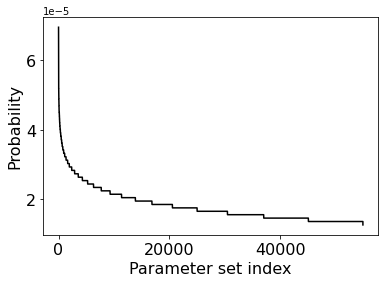

In [15]:
total_samples = np.sum(counts[sorted_counts[:n_likely_pars]])
pctge = counts[sorted_counts[:n_likely_pars]]/total_samples
x_data = range(len(counts[sorted_counts[:n_likely_pars]]))
ax2 = plt.subplot()
ax2.plot(x_data, pctge, color='k')
ax2.set_xlabel('Parameter set index')
ax2.set_ylabel('Probability')
# ax2.tick_params(axis='y', labelcolor='blue')

ax2.tick_params(axis='both', labelsize=16)
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

plt.show()
# plt.savefig('parameter_probabilities.png', dpi=150, bbox_inches='tight')

## Supplemental Table 3: Gelman-Rubin convergence check

In [16]:
# load Gelam-Rubin statistics from the PyDREAM run
gr = np.loadtxt('full_earm_2m_calibration/earm2_flat_dreamzs_5chain_data0_GelmanRubin_iteration_2000000.txt')

In [17]:
kpar_idxs = []
for i, j in enumerate(model.parameters):
    if j not in model.parameters_initial_conditions():
        kpar_idxs.append(i)

converged_pars_idxs = [kpar_idxs[i] for i,j in enumerate(gr) if j <= 1.2]
print(f'converged parameters: {len(converged_pars_idxs)}')
print(f'non converged parameters: {len(model.parameters_rules()) - len(converged_pars_idxs)}')

converged parameters: 62
non converged parameters: 43


In [18]:
gr_non_converged = [j for i,j in enumerate(gr) if j > 1.2]

In [19]:
print(min(gr_non_converged))
print(max(gr_non_converged))

1.2102987218797356
13.521783469035148


In [20]:
par_names = [model.parameters[i].name for i in kpar_idxs]

In [22]:
gr_df = pd.DataFrame(gr)
gr_df.insert(0, 'Parameter', par_names)
print(gr_df)

                                      Parameter         0
0                             bind_L_R_to_LR_kf  1.305550
1                             bind_L_R_to_LR_kr  1.193667
2                         convert_LR_to_DISC_kc  1.595003
3               bind_DISC_C8pro_to_DISCC8pro_kf  1.625665
4               bind_DISC_C8pro_to_DISCC8pro_kr  1.016520
..                                          ...       ...
100     pore_transport_complex_BakA_4_CytoCM_kr  1.049312
101  pore_transport_dissociate_BakA_4_CytoCC_kc  1.226333
102      pore_transport_complex_BakA_4_SmacM_kf  1.339660
103      pore_transport_complex_BakA_4_SmacM_kr  1.020485
104   pore_transport_dissociate_BakA_4_SmacC_kc  1.016182

[105 rows x 2 columns]


In [ ]:
gr_df.to_csv('earmv20_gelman_rubin.csv')

# Figure 6B: Distribution of 9 converged parameters

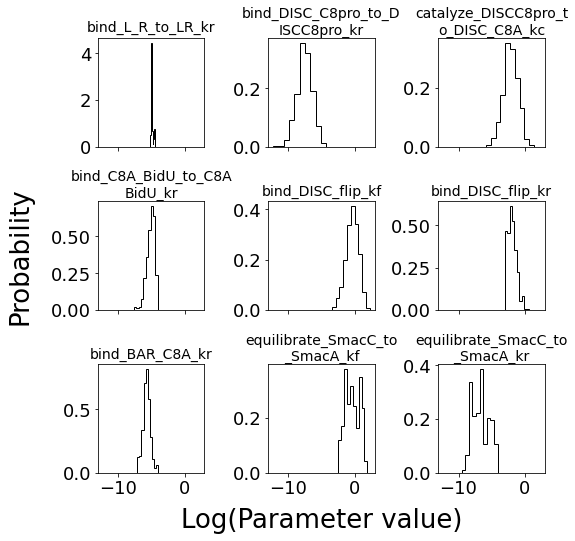

In [23]:
# Indices of parameters related to mBid interactions

rows = 3
columns = 3
counter = 0

f, axes = plt.subplots(rows, columns, figsize=(8, 8), sharex=True)
for r in range(rows):
    for c in range(columns):
        par_to_plot = converged_pars_idxs[counter]
        weights = np.ones_like(sampled_log_pars[:, par_to_plot])/float(len(sampled_log_pars[:, par_to_plot]))
        axes[r, c].hist(sampled_log_pars[:, par_to_plot], 
                        color='k', density=True, histtype='step')
        axes[r, c].set_title(label="\n".join(wrap(model.parameters[par_to_plot].name, 20)), fontdict={'fontsize':14}, wrap=True)
        axes[r, c].tick_params(axis='both', labelsize=18)
#         axes[r, c].xaxis.label.set_size(18)
#         axes[r, c].yaxis.label.set_size(18)
        # axes[r, c].set_xlim(-6, 6)
        counter += 1
        if counter >= 9:
            break

# Hide last subplots as nothing is plotted there
# axes[5, 2].axis('off')
            
ax = f.add_subplot(111, frameon=False)
f.subplots_adjust(wspace=0.6)
f.subplots_adjust(hspace=0.5)
# hide tick and tick label of the big axes
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlabel("Log(Parameter value)", fontsize=26, labelpad=35)
ax.set_ylabel("Probability", fontsize=26, labelpad=65)

f.savefig('figure6c_non_converged_parameters.png', dpi=150, bbox_inches = 'tight')

# Supplemental Figure 6a-c: distributions of all calibrated parameters

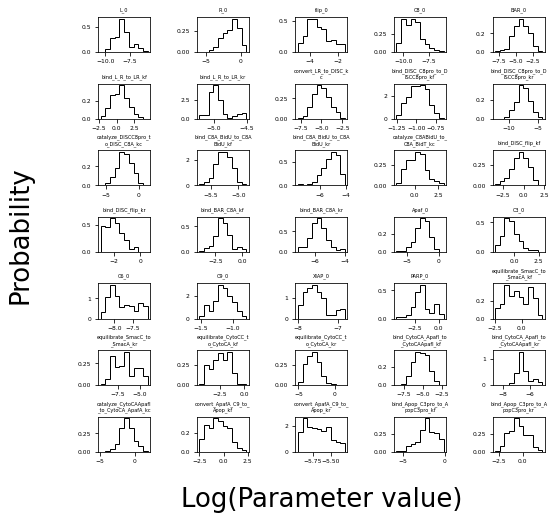

In [24]:
# Indices of parameters related to mBid interactions

rows = 7
columns = 5
counter = 0

f, axes = plt.subplots(rows, columns, figsize=(8, 8), sharex=False)
for r in range(rows):
    for c in range(columns):
        par_to_plot = range(0, 105)[counter]
        weights = np.ones_like(sampled_log_pars[:, par_to_plot])/float(len(sampled_log_pars[:, par_to_plot]))
        axes[r, c].hist(sampled_log_pars[:, par_to_plot], 
                        color='k', density=True, histtype='step')
        axes[r, c].set_title(label="\n".join(wrap(model.parameters[par_to_plot].name, 20)), fontdict={'fontsize':5}, wrap=True)
        axes[r, c].tick_params(axis='both', labelsize=6)
#         axes[r, c].xaxis.label.set_size(18)
#         axes[r, c].yaxis.label.set_size(18)
        # axes[r, c].set_xlim(-6, 6)
        counter += 1
        if counter >= 36:
            break

# Hide last subplots as nothing is plotted there
# axes[5, 2].axis('off')
            
ax = f.add_subplot(111, frameon=False)
f.subplots_adjust(wspace=0.9)
f.subplots_adjust(hspace=0.9)
# hide tick and tick label of the big axes
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlabel("Log(Parameter value)", fontsize=26, labelpad=35)
ax.set_ylabel("Probability", fontsize=26, labelpad=65)

f.savefig('distribution_parameters_supplement1.png', dpi=150, bbox_inches = 'tight')

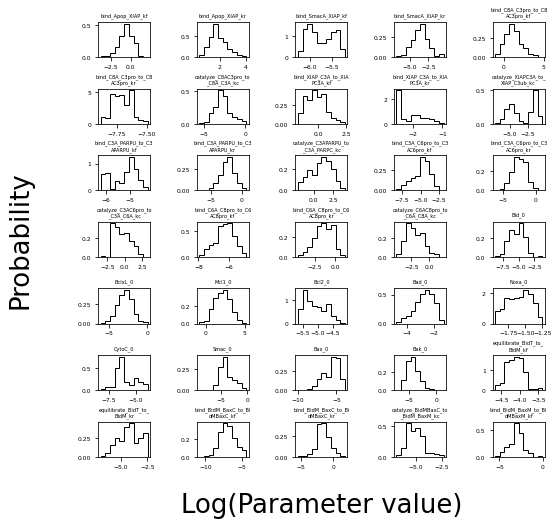

In [25]:
# Indices of parameters related to mBid interactions

rows = 7
columns = 5
counter = 36

f, axes = plt.subplots(rows, columns, figsize=(8, 8), sharex=False)
for r in range(rows):
    for c in range(columns):
        par_to_plot = range(0, 105)[counter]
        weights = np.ones_like(sampled_log_pars[:, par_to_plot])/float(len(sampled_log_pars[:, par_to_plot]))
        axes[r, c].hist(sampled_log_pars[:, par_to_plot], 
                        color='k', density=True, histtype='step')
        axes[r, c].set_title(label="\n".join(wrap(model.parameters[par_to_plot].name, 20)), fontdict={'fontsize':5}, wrap=True)
        axes[r, c].tick_params(axis='both', labelsize=6)
#         axes[r, c].xaxis.label.set_size(18)
#         axes[r, c].yaxis.label.set_size(18)
        # axes[r, c].set_xlim(-6, 6)
        counter += 1
        if counter >= 71:
            break

# Hide last subplots as nothing is plotted there
# axes[5, 2].axis('off')
            
ax = f.add_subplot(111, frameon=False)
f.subplots_adjust(wspace=0.9)
f.subplots_adjust(hspace=0.9)
# hide tick and tick label of the big axes
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlabel("Log(Parameter value)", fontsize=26, labelpad=35)
ax.set_ylabel("Probability", fontsize=26, labelpad=65)

f.savefig('distribution_parameters_supplement2.png', dpi=150, bbox_inches = 'tight')

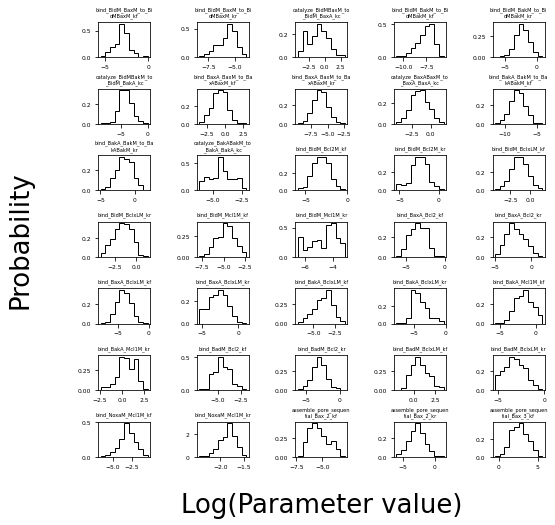

In [26]:
# Indices of parameters related to mBid interactions

rows = 7
columns = 5
counter = 70

f, axes = plt.subplots(rows, columns, figsize=(8, 8), sharex=False)
for r in range(rows):
    for c in range(columns):
        par_to_plot = range(0, 105)[counter]
        weights = np.ones_like(sampled_log_pars[:, par_to_plot])/float(len(sampled_log_pars[:, par_to_plot]))
        axes[r, c].hist(sampled_log_pars[:, par_to_plot], 
                        color='k', density=True, histtype='step')
        axes[r, c].set_title(label="\n".join(wrap(model.parameters[par_to_plot].name, 20)), fontdict={'fontsize':5}, wrap=True)
        axes[r, c].tick_params(axis='both', labelsize=6)
#         axes[r, c].xaxis.label.set_size(18)
#         axes[r, c].yaxis.label.set_size(18)
        # axes[r, c].set_xlim(-6, 6)
        counter += 1
        if counter >= 105:
            break

# Hide last subplots as nothing is plotted there
# axes[5, 2].axis('off')
            
ax = f.add_subplot(111, frameon=False)
f.subplots_adjust(wspace=0.9)
f.subplots_adjust(hspace=0.9)
# hide tick and tick label of the big axes
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlabel("Log(Parameter value)", fontsize=26, labelpad=35)
ax.set_ylabel("Probability", fontsize=26, labelpad=65)

f.savefig('distribution_parameters_supplement3.png', dpi=150, bbox_inches = 'tight')

## helper functions

In [28]:
def remove_nan_trajectories(simulation_result):
    """
    Removes simulations that have NaNs in their trajectories
    """
    # convert to 3D ndarray
    sim_tr = np.array(simulation_result.species)
    # Find nans in the array
    sim_with_nan = np.isnan(sim_tr).any(axis=(1, 2))
    # Take only the simulations, parameters and tout indices that don't have nans
    sim_tr_without_nan = sim_tr[~sim_with_nan]
    sim_pars_without_nan = simulation_result.param_values[~sim_with_nan]
    sim_tout_without_nan = simulation_result.tout[~sim_with_nan]
    # create new simulation result object
    sim_result_without_nan = SimulationResult(simulator=None, tout=sim_tout_without_nan,
                                             trajectories=sim_tr_without_nan, model=simulation_result._model,
                                             param_values=sim_pars_without_nan)
    return sim_result_without_nan, sim_with_nan

def simulation_result_from_cluster(simulation_result, cluster_idxs):
    """
    Creates new SimulationResult object from the passed simulation
    and the indices of the simulations to keep
    """
    sim_tr = np.array(simulation_result.species)
    sim_cluster = sim_tr[cluster_idxs]
    sim_pars_cluster = simulation_result.param_values[cluster_idxs]
    sim_tout_cluster = simulation_result.tout[cluster_idxs]
    sim_result_cluster = SimulationResult(simulator=None, tout=sim_tout_cluster,
                                         trajectories=sim_cluster, model=simulation_result._model,
                                         param_values=sim_pars_cluster)
    return sim_result_cluster


# Simulate model with calibrated parameter vectors

In [27]:
##### DO NOT CHANGE: CODE TO SIMULATE MODEL WITH PYDREAM PARAMETER VECTORS ###
# tspan = np.linspace(0, 20000, 501)
# sim = ScipyOdeSimulator(model, tspan, verbose=False, compiler='cython').run(param_values=all_pars, num_processors=150)
# sim.save('simululations_earm_nsims54953.h5')
#####
tspan = np.linspace(0, 20000, 501)
sim = SimulationResult.load('simulations_earm_nsims54953.h5')

In [29]:
# remove simulations that have NaNs in their trajectories
wt_sim_without_nan, wt_sim_nan_mask = remove_nan_trajectories(sim)
print(wt_sim_without_nan.nsims)

54925


# Supplementary Figure 3: Simulations fit experimental data

In [30]:
# load experimental data
fret_data = pd.read_csv('../fluorescence_data.csv')
fret_data.head()

,# Time,IC-RP,norm_IC-RP,nrm_var_IC-RP,IMS-RP,IMS-RP step,VAR,EC-RP,norm_EC-RP,nrm_var_EC-RP,Condition
0,3,0.7063,0.0,0.0006,0.0,0,1,0.4451,0.0020,0.0003,Control
1,6,0.7063,0.0,0.0006,0.0,0,1,0.4460,0.0018,0.0003,Control
2,9,0.7063,0.0,0.0006,0.0,0,1,0.4459,0.0015,0.0003,Control
3,12,0.7063,0.0,0.0006,0.0,0,1,0.4458,0.0051,0.0003,Control
4,15,0.7063,0.0,0.0006,0.0,0,1,0.4474,0.0038,0.0002,Control


In [31]:
vs = VisualizeSimulations(model, wt_sim_without_nan, clusters=None)

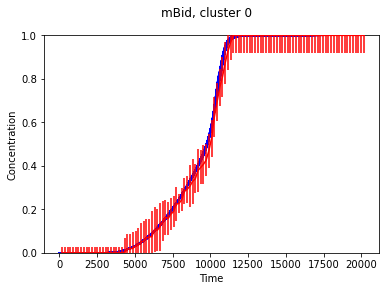

In [32]:
mbid_plot = vs.plot_cluster_dynamics(['mBid'], norm=True, 
                                     x_data={'mBid': fret_data['# Time']*60}, 
                                     y_data={'mBid': fret_data['norm_IC-RP']}, 
                                     y_error={'mBid': fret_data['nrm_var_IC-RP']** 0.5})

In [ ]:
# Add legend to tBid figure

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

blue_patch = mpatches.Patch(color='blue', label='mBid sim',)
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='mBid exp. data')
tbid_plot['comp0_cluster0'][1].legend(handles=[blue_patch, 
                                                         red_line], 
                                                loc=2, fontsize=13)
tbid_plot['comp0_cluster0'][1].tick_params(axis='both', 
                                                     labelsize=16)
tbid_plot['comp0_cluster0'][1].xaxis.label.set_size(16)
tbid_plot['comp0_cluster0'][1].yaxis.label.set_size(16)
tbid_plot['comp0_cluster0'][0].savefig('mbid_sim_data.png', 
                                                 dpi=150, 
                                                 bbox_inches = "tight")

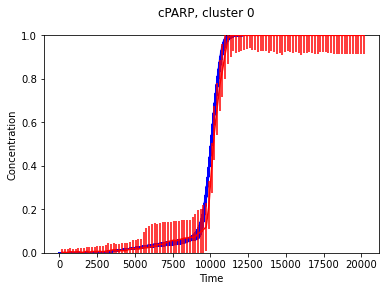

In [33]:
cparp_plot = vs.plot_cluster_dynamics(['cPARP'], norm=True,
                                      x_data={'cPARP': fret_data['# Time']*60}, 
                                      y_data={'cPARP': fret_data['norm_EC-RP']}, 
                                      y_error={'cPARP': fret_data['nrm_var_EC-RP']** 0.5})

In [ ]:
# Add legend to tBid figure

blue_patch = mpatches.Patch(color='blue', label='cPARP sim',)
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='cPARP exp. data')
cparp_plot['comp0_cluster0'][1].legend(handles=[blue_patch, 
                                                           red_line], 
                                                  loc=2, fontsize=13)
cparp_plot['comp0_cluster0'][1].tick_params(axis='both', 
                                                       labelsize=16)
cparp_plot['comp0_cluster0'][1].xaxis.label.set_size(16)
cparp_plot['comp0_cluster0'][1].yaxis.label.set_size(16)
cparp_plot['comp0_cluster0'][0].savefig('cparp_sim_data.png',
                                                   dpi=150, 
                                                   bbox_inches = "tight")

# Clustering analysis of signal flux analysis in full EARM

## Figure 6B. Modes of signal execution

In [34]:
signs_truncated, paths_prod = SeqAnalysis.load('s25_consumption_depth25_om1_dissmatrix_labels_reorganized.h5')

### DO NOT CHANGE: code to obtain sequences shown in paper ###
# dp = PysbDomPath(model, sim)
# signs_prod, paths_prod = dp.get_path_signatures('s25', 'consumption', depth=25, dom_om=1, num_processors=150)
# signs_truncated = signs_prod.truncate_sequences(260)
# signs_truncated.dissimilarity_matrix(num_processors=1)
# signs_truncated.silhouette_score_spectral_range(20 ,num_processors=50)  # n_clusters best silhouette score: 11
# signs_truncated.spectral_clustering(11, num_processors=50)
# signs_truncated.save('s25_consumption_depth25_om1.h5', paths_prod)

### Reorganizing clustering labels for visualization purposes
# reorganized_labels = np.copy(signs_truncated.labels)
# mask_cluster0 = reorganized_labels == 0
# mask_cluster1 = reorganized_labels == 1
# mask_cluster2 = reorganized_labels == 2
# mask_cluster3 = reorganized_labels == 3
# mask_cluster4 = reorganized_labels == 4
# mask_cluster5 = reorganized_labels == 5
# mask_cluster6 = reorganized_labels == 6
# mask_cluster7 = reorganized_labels == 7
# mask_cluster8 = reorganized_labels == 8
# mask_cluster9 = reorganized_labels == 9
# mask_cluster10 = reorganized_labels == 10
# reorganized_labels[mask_cluster0] = 1
# reorganized_labels[mask_cluster1] = 11
# reorganized_labels[mask_cluster2] = 4
# reorganized_labels[mask_cluster3] = 5
# reorganized_labels[mask_cluster4] = 3
# reorganized_labels[mask_cluster5] = 9
# reorganized_labels[mask_cluster6] = 8
# reorganized_labels[mask_cluster7] = 7
# reorganized_labels[mask_cluster8] = 6
# reorganized_labels[mask_cluster9] = 10
# reorganized_labels[mask_cluster10] = 2
# signs_truncated.labels = reorganized_labels

# signs_truncated.save('s25_consumption_depth25_om1_dissmatrix_labels_reorganized.h5', dominant_paths=paths_prod)

####################

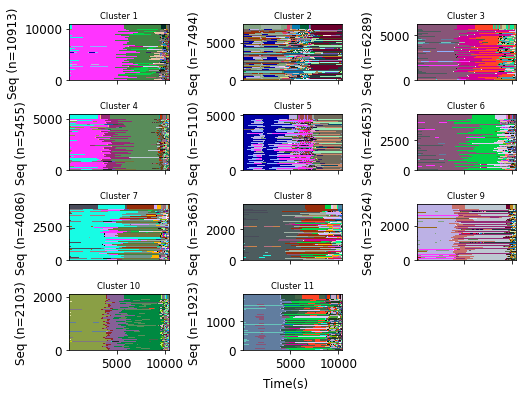

In [35]:
signs_truncated.plot_sequences(type_fig='trajectories', plot_all=False)

In [36]:
pathway1_prob = np.sum(pctge[signs_truncated.labels==1])
pathway2_prob = np.sum(pctge[signs_truncated.labels==2])
pathway3_prob = np.sum(pctge[signs_truncated.labels==3])
pathway4_prob = np.sum(pctge[signs_truncated.labels==4])
pathway5_prob = np.sum(pctge[signs_truncated.labels==5])
pathway6_prob = np.sum(pctge[signs_truncated.labels==6])
pathway7_prob = np.sum(pctge[signs_truncated.labels==7])
pathway8_prob = np.sum(pctge[signs_truncated.labels==8])
pathway9_prob = np.sum(pctge[signs_truncated.labels==9])
pathway10_prob = np.sum(pctge[signs_truncated.labels==10])
pathway11_prob = np.sum(pctge[signs_truncated.labels==11])


print(f'Probability pathway 1: {pathway1_prob*100}')
print(f'Probability pathway 2: {pathway2_prob*100}')
print(f'Probability pathway 3: {pathway3_prob*100}')
print(f'Probability pathway 4: {pathway4_prob*100}')
print(f'Probability pathway 5: {pathway5_prob*100}')
print(f'Probability pathway 6: {pathway6_prob*100}')
print(f'Probability pathway 7: {pathway7_prob*100}')
print(f'Probability pathway 8: {pathway8_prob*100}')
print(f'Probability pathway 9: {pathway9_prob*100}')
print(f'Probability pathway 10: {pathway10_prob*100}')
print(f'Probability pathway 11: {pathway11_prob*100}')

print(f'prob total {pathway1_prob+pathway2_prob+pathway3_prob+pathway4_prob+pathway5_prob+pathway6_prob+pathway7_prob+pathway8_prob+pathway9_prob+pathway10_prob+pathway11_prob}')

Probability pathway 1: 19.995835341526437
Probability pathway 2: 13.816401128954837
Probability pathway 3: 11.299324562784182
Probability pathway 4: 9.792226557420964
Probability pathway 5: 9.498256415871456
Probability pathway 6: 8.407233210120706
Probability pathway 7: 7.374671642097463
Probability pathway 8: 6.561683382328357
Probability pathway 9: 5.979022243773298
Probability pathway 10: 3.760119582400115
Probability pathway 11: 3.5152259327221906
prob total 1.0


# Figure 6D: Dominant subnetworks in Mode 1 and Mode 2

In [37]:
reprs = signs_truncated.cluster_representativeness(method='freq')

In [38]:
reprs

{1:                40.0     80.0     120.0    160.0    200.0    240.0    280.0    \
 seq_idx count                                                                  
 26770   1         1767     1767     1767     1767     1767     1767     1767   
 28991   1          354      354      354      354      354      354      354   
 39192   1          354      354      354      354      354      354      354   
 23203   1         1767     1767     1767     1767     1767     1767     1767   
 32271   1         2469     2469     2469     2469     2469     2469     2469   
 12521   1         1767     1767     1767     1767     1767     1767     1767   
 27900   1          354      354      354      354      354      354      354   
 35419   1         2469     2469     2469     2469     2469     2469     2469   
 
                320.0    360.0    400.0    ...  10040.0  10080.0  10120.0  \
 seq_idx count                             ...                              
 26770   1         1767     176

In [39]:
pd.set_option("max_columns", None) #Showing only two columns
pd.set_option("max_rows", None)

## Mode 1

In [40]:
reprs[1].iloc[:, 174].mode()

0    1576
1    1767
dtype: int64

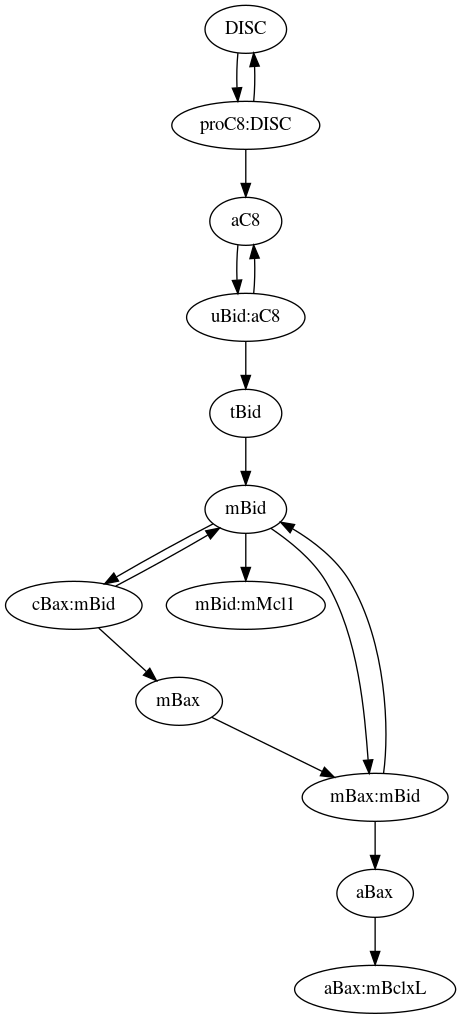

In [41]:
from IPython.display import Image
path_to_show = '1576'
visualization_path(model, paths_prod[path_to_show], 's25', 'consumption', f'path_{path_to_show}.png')
Image(filename=f'path_{path_to_show}.png') 

## Mode 2

In [42]:
reprs[2].iloc[:, 174].mode()

0    1900
dtype: int64

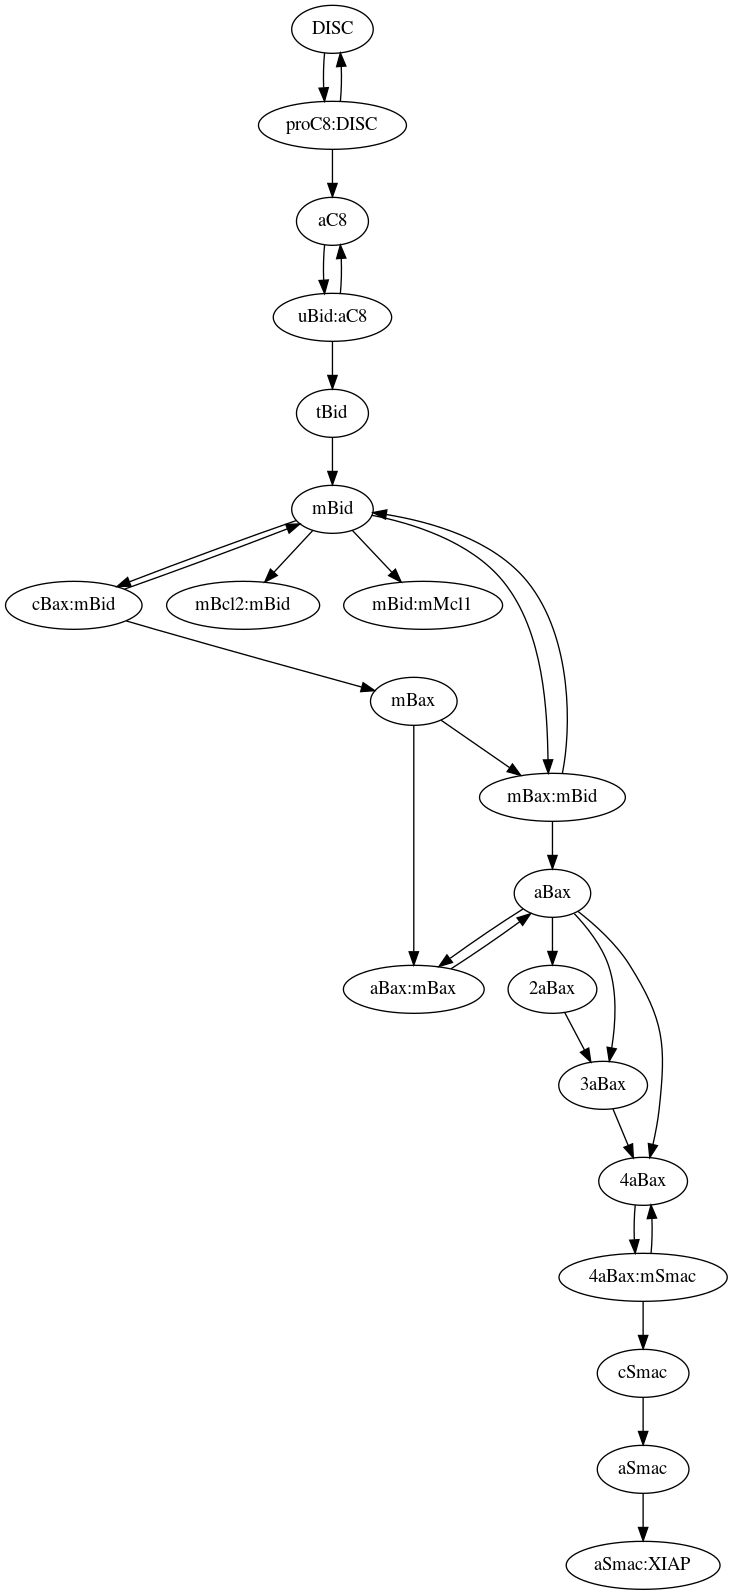

In [43]:
path_to_show = '1900'
visualization_path(model, paths_prod[path_to_show], 's25', 'consumption', f'path_{path_to_show}.png')
Image(filename=f'path_{path_to_show}.png') 

# Machine learning analysis of parameters

In [ ]:
kpar_names = [model.parameters[idx].name for idx in kpar_idxs]
#Create pandas dataframe with parameter values. Each row is a 
#unique sample from pydream (54953 unique parameter vectors)
pars_for_ml = pd.DataFrame(data=unlog_pars, columns=kpar_names)

In [ ]:
# Add clustering labels to do feature importance
pars_for_ml['cluster_label'] = signs_truncated.labels
pars_for_ml.head()

In [ ]:
# save parameters vectors with clusters to a file
pars_for_ml.to_csv('kpars_ml_data.csv', index=False)

# Knock downs in silico experiments

In [44]:
#### DO NOT CHANGE: CODE TO GET KNOCK DOWN SIMULATIONS ####
# import copy

# # MOMP knock down of Bcl2 by reducing its initial concentration by half
# all_pars_bcl2_kd = copy.deepcopy(all_pars)
# all_pars_bcl2_kd[:, 58] = all_pars_bcl2_kd[:, 58] / 2

# # MOMP knock down of Mcl1 by reducing its initial concentration by half
# all_pars_mcl1_kd = copy.deepcopy(all_pars)
# all_pars_mcl1_kd[:, 57] = all_pars_mcl1_kd[:, 57] / 2

# all_pars_mcl1_bcl2_kd = copy.deepcopy(all_pars)
# all_pars_mcl1_bcl2_kd[:, 57] = all_pars_mcl1_kd[:, 57] / 2
# all_pars_mcl1_bcl2_kd[:, 58] = all_pars_mcl1_kd[:, 58] / 2

# tspan = np.linspace(0, 20000, 501)

# sim_mcl1_kd = ScipyOdeSimulator(model, tspan, verbose=False, 
#                         compiler='cython').run(param_values=all_pars_mcl1_kd, 
#                                                num_processors=31)

# sim_mcl1_kd.save('simulations_earm_full_network_mcl1_50kd.h5')
# sim_bcl2_kd.save('simulations_earm_full_network_bcl2_50kd.h5')

########

sim_mcl1_kd = SimulationResult.load('simulations_earm_mcl1_50kd.h5')
sim_bcl2_kd = SimulationResult.load('simulations_earm_bcl2_50kd.h5')

In [45]:
mcl1_sim_without_nan, mcl1_sim_nan_mask = remove_nan_trajectories(sim_mcl1_kd)
print(mcl1_sim_without_nan.nsims)

bcl2_sim_without_nan, bcl2_sim_nan_mask = remove_nan_trajectories(sim_bcl2_kd)
print(bcl2_sim_without_nan.nsims)

# mcl1_sim_without_nan.save('sims_earm_full_network_mcl1_50kd_nonans.h5')
# bcl2_sim_without_nan.save('sims_earm_full_network_bcl2_50kd_nonans.h5')


54937
54919


In [46]:
vs_clusters = VisualizeSimulations(model, wt_sim_without_nan, clusters=None)

{'comp0_cluster0': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

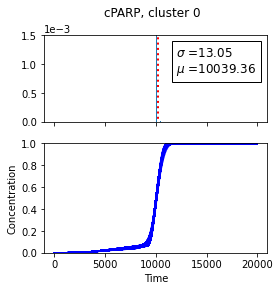

In [47]:
vs_clusters.plot_cluster_dynamics(['cPARP'], species_ftn_fit={'cPARP':sig_apop},
                                  norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
                                  figure_options={'figsize':[4,4]})

In [48]:
unclustered_times = []
clus_idxs = np.array(range(wt_sim_without_nan.nsims))
for idx in clus_idxs:
    momp_traj = wt_sim_without_nan.observables[idx]['cPARP']
    ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
#     print(idx)
    st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
    t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
    t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
    td = (t10 + t90) / 2
    unclustered_times.append(td)

clus 9996.625588816953
clus 41.32148891556533


(array([  16.,   53.,  181.,  430.,  958., 1630., 1971., 2373., 2396.,
        2230., 2150., 2319., 2642., 3252., 3624., 4301., 5276., 5758.,
        4842., 3744., 2563., 1473.,  549.,  162.,   32.]),
 array([ 9871.86604059,  9880.60160367,  9889.33716675,  9898.07272983,
         9906.80829291,  9915.54385599,  9924.27941908,  9933.01498216,
         9941.75054524,  9950.48610832,  9959.2216714 ,  9967.95723448,
         9976.69279756,  9985.42836065,  9994.16392373, 10002.89948681,
        10011.63504989, 10020.37061297, 10029.10617605, 10037.84173913,
        10046.57730221, 10055.3128653 , 10064.04842838, 10072.78399146,
        10081.51955454, 10090.25511762]),
 <BarContainer object of 25 artists>)

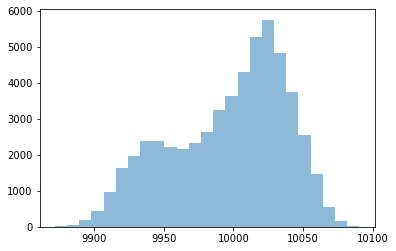

In [49]:
print('clus', np.mean(unclustered_times))
print('clus', np.std(unclustered_times))
plt.hist(unclustered_times, label='uncluster', bins=25, alpha=0.5)

## Obtaining times to death for simulations in each cluster

In [50]:
# Wild type

wt_clusters_td = []

for clus in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    wt_times = []
    wt_clus_idxs = np.array(range(54925))[signs_truncated.labels[~wt_sim_nan_mask]==clus]
    for idx in wt_clus_idxs:
        momp_traj = wt_sim_without_nan.observables[idx]['cPARP']
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
        td = (t10 + t90) / 2
        wt_times.append(td)
    wt_clusters_td.append(wt_times)

In [53]:
# Knock down
mcl1_clusters_td = []
bcl2_clusters_td = []

for clus in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    mcl1_times = []
    bcl2_times = []
    mcl1_clus_idxs = np.array(range(54937))[signs_truncated.labels[~mcl1_sim_nan_mask]==clus]
    bcl2_clus_idxs = np.array(range(54919))[signs_truncated.labels[~bcl2_sim_nan_mask]==clus]

    for idx in mcl1_clus_idxs:
        momp_traj = mcl1_sim_without_nan.observables[idx]['cPARP']
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
        td = (t10 + t90) / 2
        mcl1_times.append(td)
    
    for idx in bcl2_clus_idxs:
        momp_traj = bcl2_sim_without_nan.observables[idx]['cPARP']
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
        td = (t10 + t90) / 2
        bcl2_times.append(td)
    
    mcl1_clusters_td.append(mcl1_times)
    bcl2_clusters_td.append(bcl2_times)


# Figure 7A-upper panel: Time to death distribution in Modes 1 and 2 after a 50% KD of Mcl1  and a KD of Bcl2

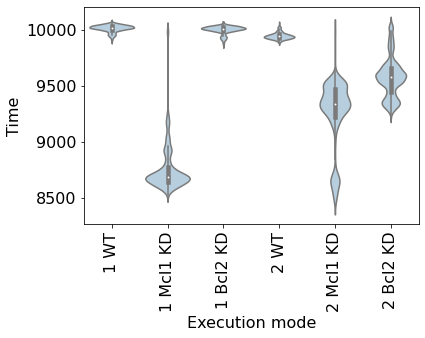

In [55]:
fig, ax = plt.subplots()

c_op1 = 0 # Index for Mode 1
c_op2 = 1 # Index for Mode 2
sns.violinplot(data=[wt_clusters_td[c_op1], mcl1_clusters_td[c_op1], bcl2_clusters_td[c_op1],
                     wt_clusters_td[c_op2], mcl1_clusters_td[c_op2], bcl2_clusters_td[c_op2]],
               scale='count', color='#b1cfe4', ax=ax)

labels=[f'{c_op1+1} WT', f'{c_op1+1} Mcl1 KD', f'{c_op1+1} Bcl2 KD', 
        f'{c_op2+1} WT', f'{c_op2+1} Mcl1 KD', f'{c_op2+1} Bcl2 KD']

ax.set_ylabel('Time', fontsize=16)
ax.set_xlabel('Execution mode', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_xticklabels(labels)
plt.xticks(rotation='vertical')
# plt.legend(loc=2)
fig.savefig('bcl2_mcl1_kd_mode1_mode2.png', bbox_inches='tight', dpi=150)


In [56]:
clus1_wt_peak_median = np.median(wt_clusters_td[0])
clus1_wt_peak_q25, clus1_wt_peak_q75 = np.percentile(wt_clusters_td[0], [25 ,75])

clus1_mcl1_peak_median = np.median(mcl1_clusters_td[0])
clus1_mcl1_peak_q25, clus1_mcl1_peak_q75 = np.percentile(mcl1_clusters_td[3], [25 ,75])

clus1_bcl2_peak_median = np.median(bcl2_clusters_td[0])
clus1_bcl2_peak_q25, clus1_bcl2_peak_q75 = np.percentile(bcl2_clusters_td[3], [25 ,75])

clus2_wt_peak_median = np.median(wt_clusters_td[1])
clus2_wt_peak_q25, clus2_wt_peak_q75 = np.percentile(wt_clusters_td[1], [25 ,75])

clus2_mcl1_peak_median = np.median(mcl1_clusters_td[1])
clus2_mcl1_peak_q25, clus2_mcl1_peak_q75 = np.percentile(mcl1_clusters_td[1], [25 ,75])

clus2_bcl2_peak_median = np.median(bcl2_clusters_td[1])
clus2_bcl2_peak_q25, clus2_bcl2_peak_q75 = np.percentile(bcl2_clusters_td[1], [25 ,75])

print('cluster 1 WT', clus1_wt_peak_median, clus1_wt_peak_q25, clus1_wt_peak_q75)
print('cluster 1 Mcl1', clus1_mcl1_peak_median, clus1_mcl1_peak_q25, clus1_mcl1_peak_q75)
print('cluster 1 Bcl2', clus1_bcl2_peak_median, clus1_bcl2_peak_q25, clus1_bcl2_peak_q75)

print('cluster 2 WT', clus2_wt_peak_median, clus2_wt_peak_q25, clus2_wt_peak_q75)
print('cluster 2 Mcl1', clus2_mcl1_peak_median, clus2_mcl1_peak_q25, clus2_mcl1_peak_q75)
print('cluster 2 Bcl2', clus2_bcl2_peak_median, clus2_bcl2_peak_q25, clus2_bcl2_peak_q75)



cluster 1 WT 10022.466507721452 10003.866444172749 10038.285754745826
cluster 1 Mcl1 8686.520612706036 8458.884865367607 8610.19204464816
cluster 1 Bcl2 10011.879372254745 9902.69109682762 9982.466077458337
cluster 2 WT 9943.659224724091 9928.478500251735 9961.587910419323
cluster 2 Mcl1 9335.854958842416 9219.22367984735 9469.72002439377
cluster 2 Bcl2 9580.001854879472 9443.480493772347 9664.497487581586


# Figure A-lower panel: Timing experiments

In [84]:
# Load EARM models that include a drug that can bind to the
# antiapoptotic proteins: Bcl2, BclxL and Mcl1. The difference
# between the models is the time at which the drug is applied

from full_earm_2m_calibration.earm2_flat_drug import model as model_drug
from full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1 import model as model_drug_4000s_xiap_mcl1
from full_earm_2m_calibration.earm2_flat_drug_4000s_xiap import model as model_drug_4000s_xiap
from full_earm_2m_calibration.earm2_flat_drug_8000s_xiap import model as model_drug_8000s_xiap

In [89]:
tspan = np.linspace(0, 20000, 501)

drug_solver_xiap_8000s = ScipyOdeSimulator(model_drug_8000s_xiap, tspan, verbose=False, 
                        compiler='cython', integrator='lsoda')

drug_solver_xiap_4000s = ScipyOdeSimulator(model_drug_4000s_xiap, tspan, verbose=False, 
                        compiler='cython', integrator='lsoda')

drug_solver_xiap_mcl1_4000s = ScipyOdeSimulator(model_drug_4000s_xiap_mcl1, tspan, verbose=False, 
                        compiler='cython', integrator='lsoda')

In [59]:
#### Bclxl, Mcl1, Bcl2 interactions with drug parameters

mode1_pars = all_pars[signs_truncated.labels==5]
mode1_npars = mode1_pars.shape[0]

kf_drug_mcl1 = np.repeat(0, mode1_npars).reshape(mode1_npars, 1)
kr_drug_mcl1 = np.repeat(0, mode1_npars).reshape(mode1_npars, 1)
kf_drug_bcl2 = np.repeat(0, mode1_npars).reshape(mode1_npars, 1)
kr_drug_bcl2 = np.repeat(0, mode1_npars).reshape(mode1_npars, 1)
kf_drug_bclxl = np.repeat(1e-6, mode1_npars).reshape(mode1_npars, 1)
kr_drug_bclxl = np.repeat(0.00072, mode1_npars).reshape(mode1_npars, 1)
k_drug_degr = np.repeat(0.1, mode1_npars).reshape(mode1_npars, 1)
kr_drug_after = np.repeat(0.1, mode1_npars).reshape(mode1_npars, 1)
drug_ic = np.repeat(500000, mode1_npars).reshape(mode1_npars, 1)
kf_time = np.repeat(1, mode1_npars).reshape(mode1_npars, 1)

mode1_pars = np.concatenate((mode1_pars, kf_drug_mcl1, kr_drug_mcl1, 
                             kf_drug_bcl2, kr_drug_bcl2,
                             kf_drug_bclxl, kr_drug_bclxl, 
                             k_drug_degr, kr_drug_after,drug_ic, kf_time), axis=1)

In [60]:
def add_drug_interations_kpars(pars, kf_drug_mcl1=0, kr_drug_mcl1=0, 
                               kf_drug_bcl2=0, kr_drug_bcl2=0,
                               kf_drug_bclxl=0, kr_drug_bclxl=0,
                               kf_drug_xiap=0, kr_drug_xiap=0,
                               k_drug_degr=0, kr_drug_after=0,
                               drug_ic=0):
    """
    Assigns values to drug - antiapoptotic protein kinetic parameters
    """
    npars = pars.shape[0]
    
    kf_drug_mcl1 = np.repeat(kf_drug_mcl1, npars).reshape(npars, 1)
    kr_drug_mcl1 = np.repeat(kr_drug_mcl1, npars).reshape(npars, 1)
    kf_drug_bcl2 = np.repeat(kf_drug_bcl2, npars).reshape(npars, 1)
    kr_drug_bcl2 = np.repeat(kr_drug_bcl2, npars).reshape(npars, 1)
    kf_drug_bclxl = np.repeat(kf_drug_bclxl, npars).reshape(npars, 1)
    kr_drug_bclxl = np.repeat(kr_drug_bclxl, npars).reshape(npars, 1)
    kf_drug_xiap = np.repeat(kf_drug_xiap, npars).reshape(npars, 1)
    kr_drug_xiap = np.repeat(kr_drug_xiap, npars).reshape(npars, 1)
    k_drug_degr = np.repeat(k_drug_degr, npars).reshape(npars, 1)
    kr_drug_after = np.repeat(kr_drug_after, npars).reshape(npars, 1)
    drug_ic = np.repeat(drug_ic, npars).reshape(npars, 1)
    kf_time = np.repeat(1, npars).reshape(npars, 1)
    
    mode_pars_drug = np.concatenate((pars, kf_drug_mcl1, kr_drug_mcl1, 
                                      kf_drug_bcl2, kr_drug_bcl2,
                                      kf_drug_bclxl, kr_drug_bclxl, 
                                      kf_drug_xiap, kr_drug_xiap,
                                      k_drug_degr, kr_drug_after,drug_ic, kf_time), axis=1)
    return mode_pars_drug

In [103]:
mode1_pars_drug_4000 = all_pars[signs_truncated.labels==1]
mode1_npars_drug_4000 = mode1_pars_drug_4000.shape[0]

# Drug only binds XIAP
mode1_pars_drug_4000_xiap = add_drug_interations_kpars(mode1_pars_drug_4000, 
                                                       kf_drug_xiap=1e-6, kr_drug_xiap=0.0000072,
                                                       k_drug_degr=0.1, kr_drug_after=0.1,drug_ic=500000)
# Drug binds XIAP and Mcl1
mode1_pars_drug_4000_xiap_mcl1 = add_drug_interations_kpars(mode1_pars_drug_4000, 
                                                            kf_drug_mcl1=1e-6, kr_drug_mcl1=0.0000072, 
                                                            kf_drug_xiap=1e-6, kr_drug_xiap=0.0000072,
                                                            k_drug_degr=0.1, kr_drug_after=0.1,drug_ic=375000)

## Drug binds XIAP at 8000 s

In [62]:
### DO NOT CHANGE: CODE TO RUN SIMULATION
# sim_drug_xiap_8000 = drug_solver_xiap_8000s.run(param_values=mode1_pars_drug_4000_xiap, 
#                                      num_processors=30, timeout=30)
# sim_drug_xiap_8000.save('sim_drug_xiap_8000.h5')

sim_drug_xiap_8000 = SimulationResult.load('sim_drug_xiap_8000.h5')

100%|██████████| 10913/10913 [59:30<00:00,  3.84it/s] 

In [63]:
drug_xiap_sim_without_nan_8000, drug_xiap_sim_nan_mask_8000 = remove_nan_trajectories(sim_drug_xiap_8000)
print(drug_xiap_sim_without_nan_8000.nsims)

10913


100%|██████████| 10913/10913 [1:00:14<00:00,  3.02it/s]


{'comp0_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp1_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp2_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp3_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp4_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp5_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

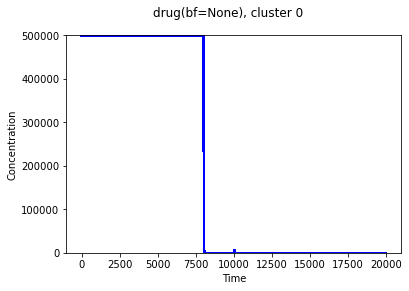

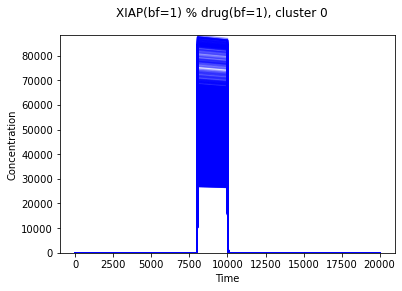

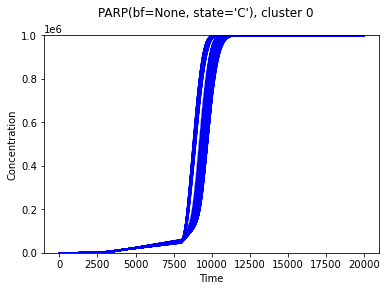

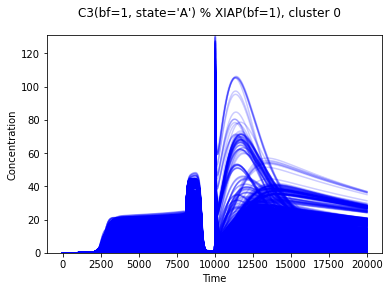

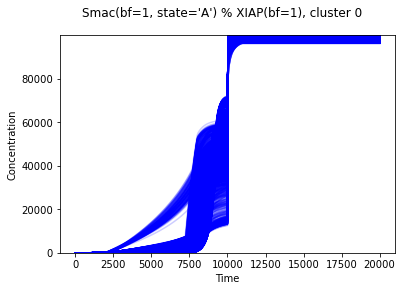

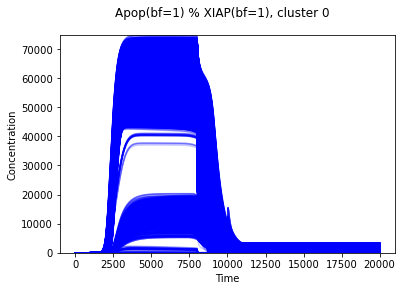

In [64]:
vs_clusters_xiap_8000 = VisualizeSimulations(model_drug_8000s_xiap, drug_xiap_sim_without_nan_8000, clusters=None)
# vs_clusters2.plot_cluster_dynamics(['cPARP'], species_ftn_fit={'cPARP':sig_apop},
#                                   norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
#                                   figure_options={'figsize':[4,4]})
vs_clusters_xiap_8000.plot_cluster_dynamics([0, 30, 45, 40, 78, 82])

## Drug binds XIAP at 4000s

In [65]:
### DO NOT CHANGE: CODE TO RUN SIMULATION
# sim_drug_xiap_4000 = drug_solver_xiap_4000s.run(param_values=mode1_pars_drug_4000_xiap, 
#                                      num_processors=30, timeout=30)
# sim_drug_xiap_4000.save('sim_drug_xiap_4000.h5')

sim_drug_xiap_4000 = SimulationResult.load('sim_drug_xiap_4000.h5')

100%|█████████▉| 10912/10913 [1:01:22<00:00,  2.70it/s]

In [66]:
drug_xiap_sim_without_nan_4000, drug_xiap_sim_nan_mask_4000 = remove_nan_trajectories(sim_drug_xiap_4000)
print(drug_xiap_sim_without_nan_4000.nsims)

10913


100%|██████████| 10913/10913 [1:02:19<00:00,  2.92it/s]


{'comp0_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp1_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp2_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp3_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp4_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp5_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp6_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp7_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

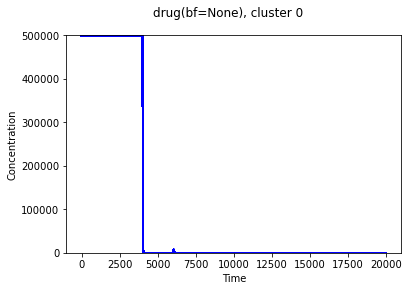

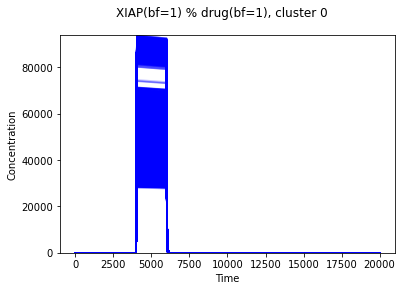

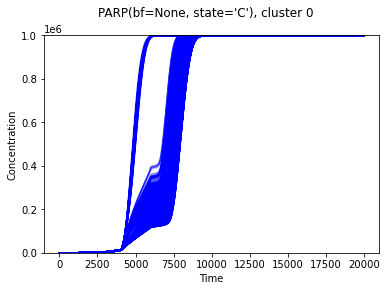

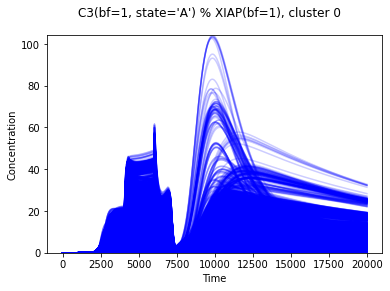

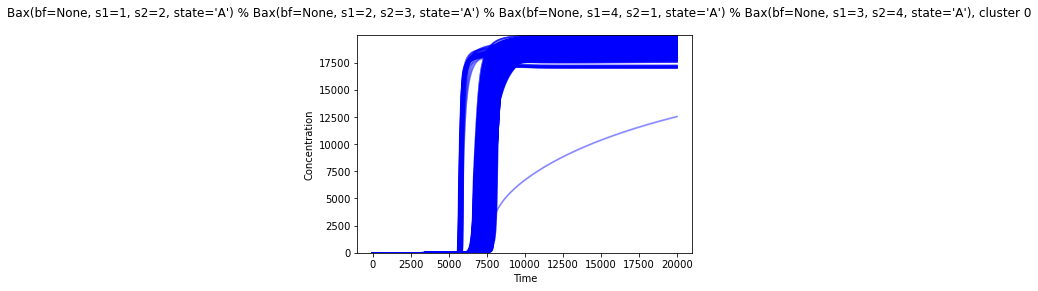

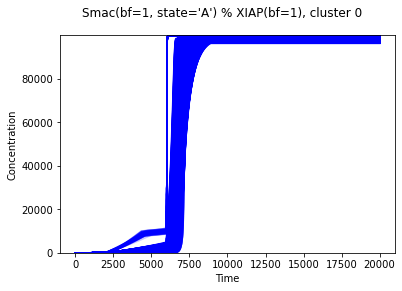

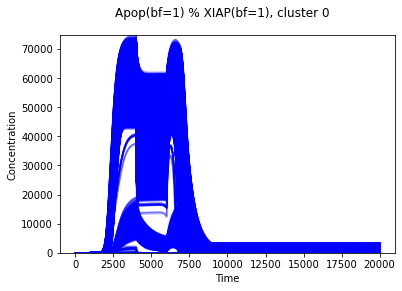

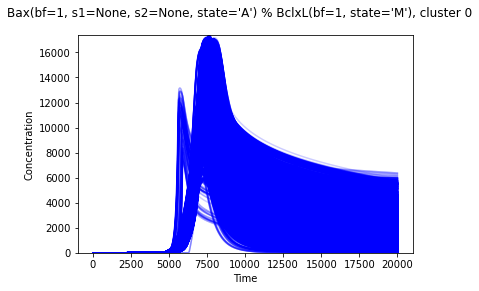

In [67]:
vs_clusters_xiap_4000 = VisualizeSimulations(model_drug_4000s_xiap, drug_xiap_sim_without_nan_4000, clusters=None)
# vs_clusters2.plot_cluster_dynamics(['cPARP'], species_ftn_fit={'cPARP':sig_apop},
#                                   norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
#                                   figure_options={'figsize':[4,4]})
vs_clusters_xiap_4000.plot_cluster_dynamics([0, 30, 45, 40, 70, 78, 82, 64])

## Drug binds XIAP and Mcl1 at 4000 s

In [104]:
sim_drug_xiap_mcl1_4000 = drug_solver_xiap_mcl1_4000s.run(param_values=mode1_pars_drug_4000_xiap_mcl1, 
                                     num_processors=100, timeout=30)

  2%|▏         | 198/10913 [02:45<40:27,  4.41it/s]2021-01-27 14:43:51.407 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 115 has timeout
2021-01-27 14:43:51.419 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 116 has timeout
2021-01-27 14:43:51.420 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 118 has timeout
2021-01-27 14:43:51.421 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 120 has timeout
2021-01-27 14:43:51.422 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 131 has timeout
2021-01-27 14:43:51.423 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 144 has timeout
2021-01-27 14:43:51.424 - pysb.simulator.scipyode - WARNING -

2021-01-27 14:49:37.733 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 824 has timeout
2021-01-27 14:49:37.734 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 827 has timeout
2021-01-27 14:49:37.736 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 834 has timeout
2021-01-27 14:49:37.737 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 836 has timeout
2021-01-27 14:49:37.738 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 838 has timeout
2021-01-27 14:49:37.739 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 845 has timeout
2021-01-27 14:49:37.741 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xi

2021-01-27 14:51:37.050 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1344 has timeout
2021-01-27 14:51:37.052 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1358 has timeout
2021-01-27 14:51:37.054 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1359 has timeout
2021-01-27 14:51:37.059 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1360 has timeout
2021-01-27 14:51:37.061 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1362 has timeout
2021-01-27 14:51:37.065 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1366 has timeout
2021-01-27 14:51:37.066 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_40

2021-01-27 14:54:36.152 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1883 has timeout
2021-01-27 14:54:36.155 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1887 has timeout
2021-01-27 14:54:36.157 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1889 has timeout
2021-01-27 14:54:36.158 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1897 has timeout
2021-01-27 14:54:36.160 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1914 has timeout
2021-01-27 14:54:36.162 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 1935 has timeout
2021-01-27 14:54:36.165 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_40

 28%|██▊       | 3047/10913 [19:47<2:54:11,  1.33s/it]2021-01-27 15:00:53.644 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 2724 has timeout
2021-01-27 15:00:53.646 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 2728 has timeout
2021-01-27 15:00:53.648 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 2731 has timeout
2021-01-27 15:00:53.650 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 2737 has timeout
2021-01-27 15:00:53.651 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 2739 has timeout
2021-01-27 15:00:53.652 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 2742 has timeout
2021-01-27 15:00:53.654 - pysb.simulator.scipyode - 

2021-01-27 15:01:25.774 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3153 has timeout
 31%|███       | 3364/10913 [21:18<26:45,  4.70it/s]2021-01-27 15:02:23.976 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3263 has timeout
2021-01-27 15:02:23.978 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3264 has timeout
2021-01-27 15:02:23.980 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3265 has timeout
2021-01-27 15:02:23.981 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3266 has timeout
2021-01-27 15:02:23.982 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3267 has timeout
2021-01-27 15:02:23.984 - pysb.simulator.scipyode - WA

2021-01-27 15:05:39.323 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3772 has timeout
 37%|███▋      | 3993/10913 [25:06<2:34:12,  1.34s/it]2021-01-27 15:06:12.191 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3958 has timeout
2021-01-27 15:06:15.065 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 3959 has timeout
 40%|████      | 4377/10913 [27:24<2:17:37,  1.26s/it]2021-01-27 15:08:30.721 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4092 has timeout
2021-01-27 15:08:30.725 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4097 has timeout
2021-01-27 15:08:30.726 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4099 has timeou

2021-01-27 15:09:31.717 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4555 has timeout
 42%|████▏     | 4578/10913 [28:32<1:30:04,  1.17it/s]2021-01-27 15:09:37.918 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4558 has timeout
2021-01-27 15:09:37.924 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4560 has timeout
 43%|████▎     | 4647/10913 [28:49<1:17:56,  1.34it/s]2021-01-27 15:09:55.316 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4590 has timeout
2021-01-27 15:09:57.381 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4603 has timeout
2021-01-27 15:09:59.543 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 4606 has timeou

2021-01-27 15:13:54.840 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5157 has timeout
2021-01-27 15:13:54.843 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5159 has timeout
2021-01-27 15:13:54.844 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5160 has timeout
2021-01-27 15:13:54.845 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5163 has timeout
2021-01-27 15:13:54.846 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5165 has timeout
2021-01-27 15:13:54.847 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5167 has timeout
2021-01-27 15:13:54.849 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_40

2021-01-27 15:19:36.508 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5946 has timeout
2021-01-27 15:19:36.510 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5950 has timeout
2021-01-27 15:19:36.525 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5951 has timeout
2021-01-27 15:19:36.526 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5952 has timeout
2021-01-27 15:19:36.528 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5953 has timeout
2021-01-27 15:19:36.529 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 5954 has timeout
2021-01-27 15:19:36.530 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_40

2021-01-27 15:23:30.279 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 6612 has timeout
2021-01-27 15:23:30.280 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 6619 has timeout
2021-01-27 15:23:30.283 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 6632 has timeout
2021-01-27 15:23:30.288 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 6636 has timeout
2021-01-27 15:23:30.289 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 6639 has timeout
2021-01-27 15:23:30.290 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 6645 has timeout
2021-01-27 15:23:30.291 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_40

 68%|██████▊   | 7452/10913 [45:38<46:40,  1.24it/s]  2021-01-27 15:26:44.833 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7414 has timeout
2021-01-27 15:26:46.581 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7416 has timeout
 70%|███████   | 7652/10913 [46:43<29:57,  1.81it/s]2021-01-27 15:27:49.551 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7552 has timeout
2021-01-27 15:27:49.556 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7553 has timeout
2021-01-27 15:27:49.557 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7554 has timeout
2021-01-27 15:27:49.561 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7556 has timeout


2021-01-27 15:31:07.484 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7922 has timeout
2021-01-27 15:31:07.485 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7927 has timeout
2021-01-27 15:31:07.486 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7930 has timeout
2021-01-27 15:31:07.487 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7939 has timeout
2021-01-27 15:31:07.488 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7942 has timeout
2021-01-27 15:31:07.489 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 7944 has timeout
2021-01-27 15:31:07.490 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_40

 79%|███████▉  | 8638/10913 [52:54<33:40,  1.13it/s]2021-01-27 15:34:00.409 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 8627 has timeout
2021-01-27 15:34:02.054 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 8628 has timeout
 79%|███████▉  | 8669/10913 [53:02<25:46,  1.45it/s]2021-01-27 15:34:08.073 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 8646 has timeout
2021-01-27 15:34:08.075 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 8658 has timeout
2021-01-27 15:34:11.629 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 8664 has timeout
2021-01-27 15:34:13.507 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 8666 has timeout
 8

2021-01-27 15:38:40.228 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9309 has timeout
2021-01-27 15:38:40.231 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9311 has timeout
2021-01-27 15:38:40.234 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9315 has timeout
2021-01-27 15:38:40.255 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9374 has timeout
2021-01-27 15:38:40.259 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9389 has timeout
2021-01-27 15:38:40.262 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9392 has timeout
2021-01-27 15:38:40.283 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_40

2021-01-27 15:43:08.515 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9961 has timeout
2021-01-27 15:43:08.517 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9993 has timeout
2021-01-27 15:43:08.526 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 9996 has timeout
2021-01-27 15:43:08.527 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10007 has timeout
2021-01-27 15:43:08.528 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10013 has timeout
2021-01-27 15:43:08.529 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10016 has timeout
2021-01-27 15:43:08.530 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug

100%|█████████▉| 10868/10913 [1:06:03<00:08,  5.23it/s]2021-01-27 15:47:09.193 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10718 has timeout
2021-01-27 15:47:09.196 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10786 has timeout
2021-01-27 15:47:09.198 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10787 has timeout
2021-01-27 15:47:09.200 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10789 has timeout
2021-01-27 15:47:09.203 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10790 has timeout
2021-01-27 15:47:09.204 - pysb.simulator.scipyode - WARNING - [full_earm_2m_calibration.earm2_flat_drug_4000s_xiap_mcl1] Simulation 10798 has timeout
2021-01-27 15:47:09.206 - pysb.simulator.scip

In [105]:
drug_xiap_bclxl_sim_without_nan_4000, drug_xiap_bclxl_sim_nan_mask_4000 = remove_nan_trajectories(sim_drug_xiap_mcl1_4000)
print(drug_xiap_bclxl_sim_without_nan_4000.nsims)

10071


100%|██████████| 10913/10913 [1:15:57<00:00,  2.39it/s]


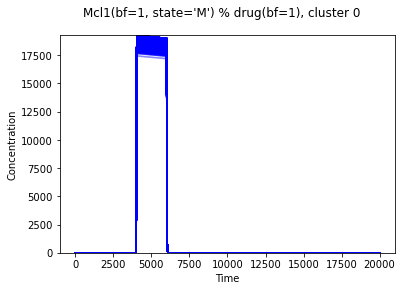

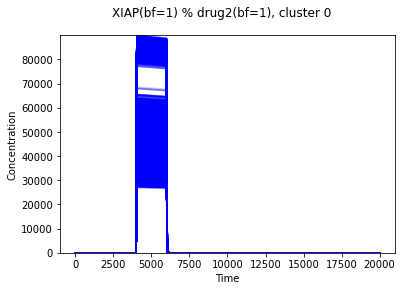

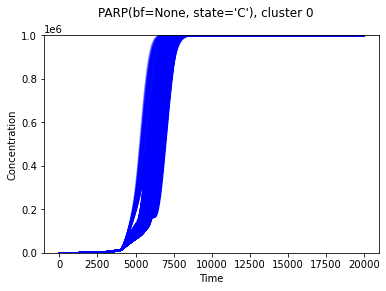

In [106]:
vs_clusters_xiap_bclxl_4000 = VisualizeSimulations(model_drug_4000s_xiap_mcl1, drug_xiap_bclxl_sim_without_nan_4000, clusters=None)
# vs_clusters2.plot_cluster_dynamics(['cPARP'], species_ftn_fit={'cPARP':sig_apop},
#                                   norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
#                                   figure_options={'figsize':[4,4]})
bax_fig = vs_clusters_xiap_bclxl_4000.plot_cluster_dynamics([28, 31, 46])

In [107]:
# XIAP inhibition
xiap_c1_drug_8000_td = []
xiap_c1_drug_4000_td = []
xiap_mcl1_c1_drug_4000_td = []

clus = 1

xiap_4000_times = []
xiap_8000_times = []

sim_clus1_idxs = np.array(range(10911))[signs_truncated.labels[signs_truncated.labels==clus]]

def get_sim_tdeath(sim):
    """
    sim: pysb.SimulationResult
    """
    sims_tdeath = []
    for idx in range(sim.nsims):
        momp_traj = sim.observables[idx]['cPARP']
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
        td = (t10 + t90) / 2
        sims_tdeath.append(td)
    return sims_tdeath
    
        
xiap_c1_drug_8000_td = get_sim_tdeath(sim_drug_xiap_8000)
xiap_c1_drug_4000_td = get_sim_tdeath(sim_drug_xiap_4000)
xiap_mcl1_c1_drug_4000_td = get_sim_tdeath(drug_xiap_bclxl_sim_without_nan_4000)

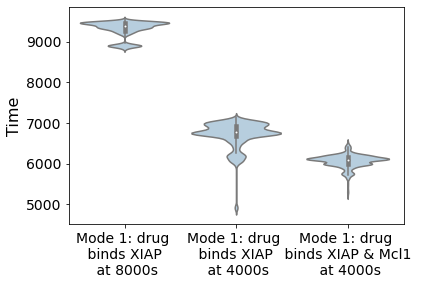

In [108]:
fig_drug, ax_drug = plt.subplots()

sns.violinplot(data=[xiap_c1_drug_8000_td, xiap_c1_drug_4000_td, xiap_mcl1_c1_drug_4000_td],
               scale='count', color='#b1cfe4', ax=ax_drug)
labels=['Mode 1: drug \n binds XIAP \n at 8000s', 
        'Mode 1: drug \n binds XIAP \n at 4000s', 'Mode 1: drug \n binds XIAP & Mcl1 \n at 4000s']

ax_drug.set_ylabel('Time', fontsize=16)
# ax_drug.set_xlabel('Execution mode', fontsize=16)
ax_drug.tick_params(axis='both', which='major', labelsize=14)
ax_drug.tick_params(axis='both', which='minor', labelsize=14)
ax_drug.set_xticklabels(labels)

fig_drug.savefig('drug_xiap_4000_8000.png', bbox_inches='tight', dpi=150)

In [109]:
clus1_wt_peak_median = np.median(wt_clusters_td[1])
clus1_wt_peak_q25, clus1_wt_peak_q75 = np.percentile(wt_clusters_td[1], [25 ,75])

clus1_8000_xiap_peak_median = np.median(xiap_c1_drug_8000_td)
clus1_8000_xiap_peak_q25, clus1_8000_xiap_peak_q75 = np.percentile(xiap_c1_drug_8000_td, [25 ,75])

clus1_4000_xiap_peak_median = np.median(xiap_c1_drug_4000_td)
clus1_4000_xiap_peak_q25, clus1_4000_xiap_peak_q75 = np.percentile(xiap_c1_drug_4000_td, [25 ,75])

clus1_4000_xiap_mcl1_peak_median = np.median(xiap_mcl1_c1_drug_4000_td)
clus1_4000_xiap_mcl1_peak_q25, clus1_4000_xiap_mcl1_peak_q75 = np.percentile(xiap_mcl1_c1_drug_4000_td, [25 ,75])

print('cluster 1 WT: ', clus1_wt_peak_median, clus1_wt_peak_q25, clus1_wt_peak_q75)
print('cluster 1 8000 XIAP: ', clus1_8000_xiap_peak_median, clus1_8000_xiap_peak_q25, clus1_8000_xiap_peak_q75)
print('cluster 1 4000 XIAP: ', clus1_4000_xiap_peak_median, clus1_4000_xiap_peak_q25, clus1_4000_xiap_peak_q75)
print('cluster 1 4000 XIAP & Mcl1: ', clus1_4000_xiap_mcl1_peak_median, 
      clus1_4000_xiap_mcl1_peak_q25, clus1_4000_xiap_mcl1_peak_q75)



cluster 1 WT:  9943.659224724091 9928.478500251735 9961.587910419323
cluster 1 8000 XIAP:  9380.44800694445 9261.596488385554 9457.62886956327
cluster 1 4000 XIAP:  6766.105752929558 6666.100611439347 6933.724700416974
cluster 1 4000 XIAP & Mcl1:  6095.405095340341 5987.985083202599 6159.739479160424


# Obtain number of pathways representing execution modes

In [77]:
reprs_1 = signs_truncated.cluster_representativeness(method='freq', nrep=1)


In [78]:
subnetworks = []
for clus, rep in reprs_1.items():
    subnetworks += rep.values.tolist()[0]
    

In [79]:
print('most frequent subnetworks: ', len(set(subnetworks)))



most frequent subnetworks:  53


In [80]:
print('total number of subnetworks: ', len(signs_truncated.unique_states))



total number of subnetworks:  2067


In [ ]:
# Parameters used in supplemental videos
np.save('EARMv20_EM3', all_pars[19069])# Mode 3
np.save('EARMv20_EM4', all_pars[22323])# Mode 4
np.save('EARMv20_EM5', all_pars[36352])# Mode 5
np.save('EARMv20_EM6', all_pars[20016])# Mode 6
np.save('EARMv20_EM7', all_pars[38052])# Mode 7
np.save('EARMv20_EM8', all_pars[49986])# Mode 8
np.save('EARMv20_EM9', all_pars[21066])# Mode 9
np.save('EARMv20_EM10', all_pars[38771])# Mode 10
np.save('EARMv20_EM11', all_pars[24804])# Mode 11

In [ ]:
Mode 3: 19069
Mode 4: 22323
Mode 5: 36352
Mode 6: 20016
Mode 7: 38052
Mode 8: 49986
Mode 9: 21066
Mode 10: 38771
Mode 11: 24804